# Handwriting OCR API example

### This notebook extends the Microsoft notebook for calling for running an image through their computer vision API, to take a folder of documents and extract the text.

#### This Jupyter notebook shows you how to get started with the Cognitive Service <b>Computer Vision Handwriting OCR API</b> in Python, and how to visualize your results.

To use this notebook, you will need to get keys to <b>Computer Vision API</b>. Visit <a href="https://www.microsoft.com/cognitive-services/en-us/computer-vision-api">https://www.microsoft.com/cognitive-services/en-us/computer-vision-api</a>, and then the “Try for free” button. On the “Sign in” page, use your Microsoft account to sign in and you will be able to subscribe to Computer Vision API and get free keys (Code of Conduct and TOS). After completing the sign-up process, paste your key into the variables section below. (Either the primary or the secondary key works.)

In [1]:
import time 
import requests
import cv2
import operator
import numpy as np
import itertools

# Import library to display results
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline 
# Display images within Jupyter

In [2]:
# Variables

_url = 'https://westcentralus.api.cognitive.microsoft.com/vision/v1.0/RecognizeText'
_key = ''  #Here you have to paste your primary key
_maxNumRetries = 10

# Helper functions

In [19]:
def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:
        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429:
            print( "Message: %s" % ( response.json() ) )
            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break
        elif response.status_code == 202:
            result = response.headers['Operation-Location']
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )
        break
        
    return result

In [21]:
def getOCRTextResult( operationLocation, headers ):
    """
    Helper function to get text result from operation location

    Parameters:
    operationLocation: operationLocation to get text result, See API Documentation
    headers: Used to pass the key information
    """

    retries = 0
    result = None

    while True:
        response = requests.request('get', operationLocation, json=None, data=None, headers=headers, params=None)
        if response.status_code == 429:
            print("Message: %s" % (response.json()))
            if retries <= _maxNumRetries:
                time.sleep(1)
                retries += 1
                continue
            else:
                print('Error: failed after retrying!')
                break
        elif response.status_code == 200:
            result = response.json()
        else:
            print("Error code: %d" % (response.status_code))
            print("Message: %s" % (response.json()))
        break

    return result

In [22]:
def showResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    img = img[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img, aspect='equal')

    lines = result['recognitionResult']['lines']

    for i in range(len(lines)):
        words = lines[i]['words']
        for j in range(len(words)):
            tl = (words[j]['boundingBox'][0], words[j]['boundingBox'][1])
            tr = (words[j]['boundingBox'][2], words[j]['boundingBox'][3])
            br = (words[j]['boundingBox'][4], words[j]['boundingBox'][5])
            bl = (words[j]['boundingBox'][6], words[j]['boundingBox'][7])
            text = words[j]['text']
            x = [tl[0], tr[0], tr[0], br[0], br[0], bl[0], bl[0], tl[0]]
            y = [tl[1], tr[1], tr[1], br[1], br[1], bl[1], bl[1], tl[1]]
            line = Line2D(x, y, linewidth=3.5, color='red')
            ax.add_line(line)
            ax.text(tl[0], tl[1] - 2, '{:s}'.format(text),
            bbox=dict(facecolor='blue', alpha=0.5),
            fontsize=14, color='white')

    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.show()

# Analysis of a single image stored on disk

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


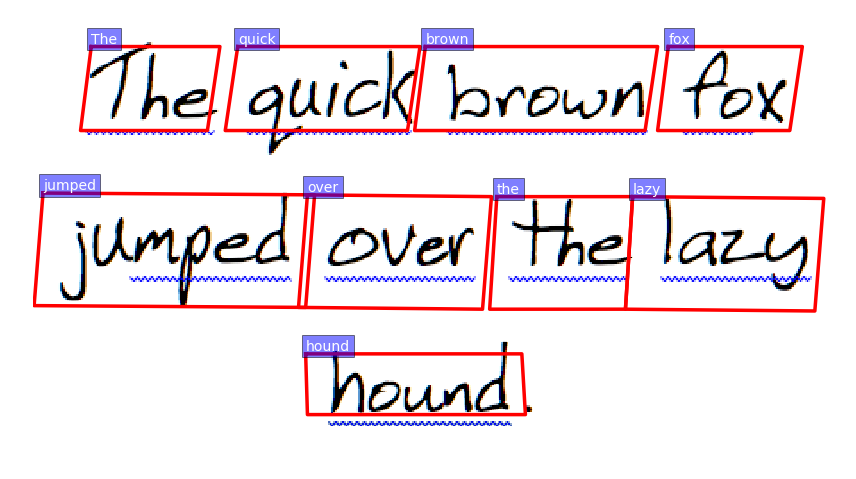

In [23]:
# Load raw image file into memory
pathToFileInDisk = r'/notebooks/Hack_ocr/download.png'
with open(pathToFileInDisk, 'rb') as f:
    data = f.read()

# Computer Vision parameters
params = {'handwriting' : 'true'}

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'

json = None

operationLocation = processRequest(json, data, headers, params)

result = None
if (operationLocation != None):
    headers = {}
    headers['Ocp-Apim-Subscription-Key'] = _key
    while True:
        time.sleep(1)
        result = getOCRTextResult(operationLocation, headers)
        if result['status'] == 'Succeeded' or result['status'] == 'Failed':
            break

# Load the original image, fetched from the URL
if result is not None and result['status'] == 'Succeeded':
    data8uint = np.fromstring(data, np.uint8)  # Convert string to an unsigned int array
    img = cv2.cvtColor(cv2.imdecode(data8uint, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    showResultOnImage(result, img)

# Loop through a folder of images saving words to list

In [24]:
import os
# Put all the image file names that sit in a folder into a list to loop through later with the oCR API 
filecontainer = [] # stores the image filenames
image_path = "/notebooks/Hack_ocr/" # your folder that holds the images

# Loop through items in folder and append to list filecontainer
for item in os.listdir(image_path):
    filecontainer.append((os.path.join(image_path,item)))
    
print(filecontainer) # print out list of image file names

['/notebooks/Hack_ocr/text_doc.png', '/notebooks/Hack_ocr/coffee.png', '/notebooks/Hack_ocr/download.png']


In [26]:
filecontainer

['/notebooks/Hack_ocr/text_doc.png',
 '/notebooks/Hack_ocr/coffee.png',
 '/notebooks/Hack_ocr/download.png']

/notebooks/Hack_ocr/text_doc.png
https://westcentralus.api.cognitive.microsoft.com/vision/v1.0/textOperations/621e3243-f1d6-42e8-9ead-4a37379b37ed


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


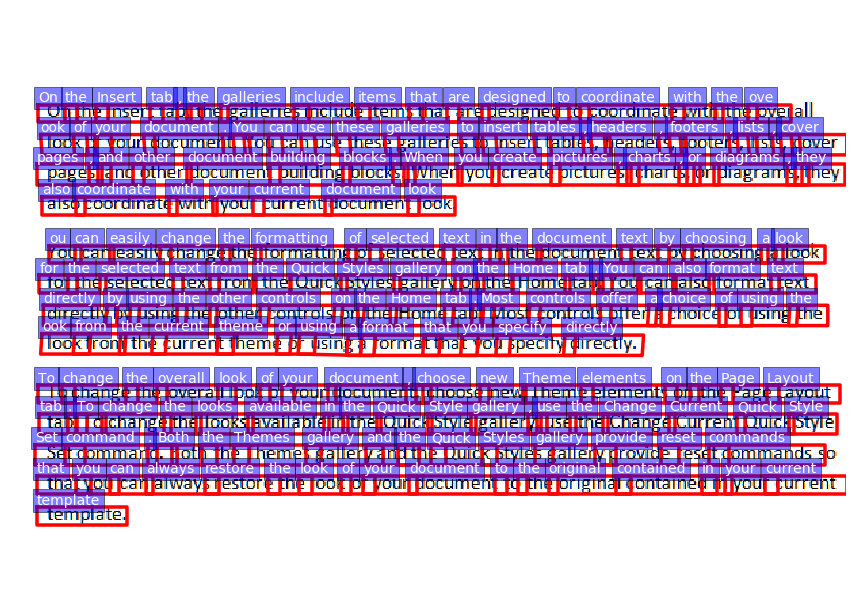

['On', 'the', 'Insert', 'tab', ',', 'the', 'galleries', 'include', 'items', 'that', 'are', 'designed', 'to', 'coordinate', 'with', 'the', 'ove', 'ook', 'of', 'your', 'document', '.', 'You', 'can', 'use', 'these', 'galleries', 'to', 'insert', 'tables', ',', 'headers', ',', 'footers', ',', 'lists', ',', 'cover', 'pages', ',', 'and', 'other', 'document', 'building', 'blocks', '.', 'When', 'you', 'create', 'pictures', ',', 'charts', ',', 'or', 'diagrams', ',', 'they', 'also', 'coordinate', 'with', 'your', 'current', 'document', 'look', 'ou', 'can', 'easily', 'change', 'the', 'formatting', 'of', 'selected', 'text', 'in', 'the', 'document', 'text', 'by', 'choosing', 'a', 'look', 'for', 'the', 'selected', 'text', 'from', 'the', 'Quick', 'Styles', 'gallery', 'on', 'the', 'Home', 'tab', '.', 'You', 'can', 'also', 'format', 'text', 'directly', 'by', 'using', 'the', 'other', 'controls', 'on', 'the', 'Home', 'tab', '.', 'Most', 'controls', 'offer', 'a', 'choice', 'of', 'using', 'the', 'ook', 'from

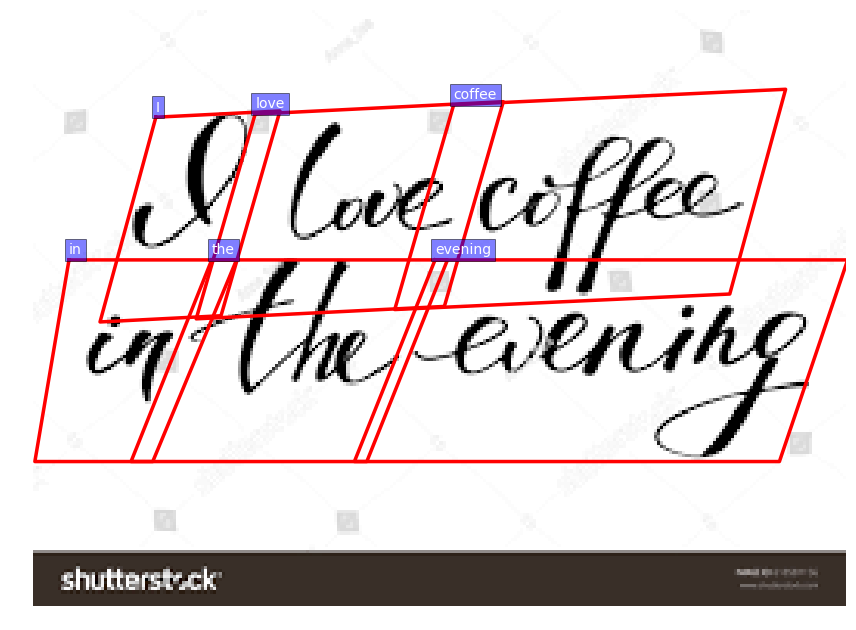

['I', 'love', 'coffee', 'in', 'the', 'evening']
/notebooks/Hack_ocr/download.png
https://westcentralus.api.cognitive.microsoft.com/vision/v1.0/textOperations/46c249cd-22b9-4e40-8e67-79dbf5464c22


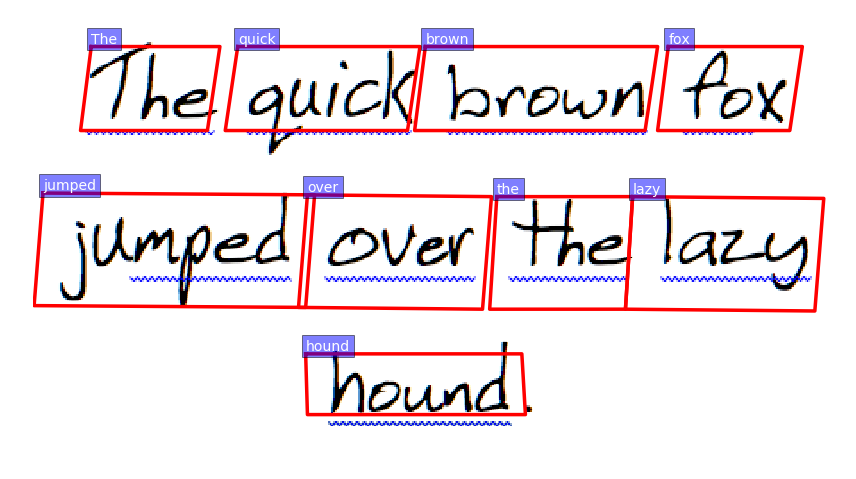

['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'hound']


In [49]:
# Load raw image file into memory
text_master=[]
text_list=[]

for file in filecontainer: 
    
    pathToFileInDisk = r'/notebooks/Hack_ocr/download.png'
    with open(file, 'rb') as f:
        data = f.read()
    
    # Computer Vision parameters
    params = {'handwriting' : 'true'}

    headers = dict()
    headers['Ocp-Apim-Subscription-Key'] = _key
    headers['Content-Type'] = 'application/octet-stream'

    json = None

    operationLocation = processRequest(json, data, headers, params)
    
    print(file)
    print(operationLocation)

    result = None
    if (operationLocation != None):
        headers = {}
        headers['Ocp-Apim-Subscription-Key'] = _key
        while True:
            time.sleep(1)
            text_list=[]
            result = getOCRTextResult(operationLocation, headers)
            res = result['recognitionResult']
            for line in res['lines']:
                for word in line['words']:
                    text_list.append((word['text']))
            if result['status'] == 'Succeeded' or result['status'] == 'Failed':
                break
    text_master.append(text_list)
    
            # Load the original image, fetched from the URL
    if result is not None and result['status'] == 'Succeeded':
        data8uint = np.fromstring(data, np.uint8)  # Convert string to an unsigned int array
        img = cv2.cvtColor(cv2.imdecode(data8uint, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        showResultOnImage(result, img)
        
    print(text_list)

In [50]:
text_master

[['On',
  'the',
  'Insert',
  'tab',
  ',',
  'the',
  'galleries',
  'include',
  'items',
  'that',
  'are',
  'designed',
  'to',
  'coordinate',
  'with',
  'the',
  'ove',
  'ook',
  'of',
  'your',
  'document',
  '.',
  'You',
  'can',
  'use',
  'these',
  'galleries',
  'to',
  'insert',
  'tables',
  ',',
  'headers',
  ',',
  'footers',
  ',',
  'lists',
  ',',
  'cover',
  'pages',
  ',',
  'and',
  'other',
  'document',
  'building',
  'blocks',
  '.',
  'When',
  'you',
  'create',
  'pictures',
  ',',
  'charts',
  ',',
  'or',
  'diagrams',
  ',',
  'they',
  'also',
  'coordinate',
  'with',
  'your',
  'current',
  'document',
  'look',
  'ou',
  'can',
  'easily',
  'change',
  'the',
  'formatting',
  'of',
  'selected',
  'text',
  'in',
  'the',
  'document',
  'text',
  'by',
  'choosing',
  'a',
  'look',
  'for',
  'the',
  'selected',
  'text',
  'from',
  'the',
  'Quick',
  'Styles',
  'gallery',
  'on',
  'the',
  'Home',
  'tab',
  '.',
  'You',
  'can',